# Classes 

In [1]:
import torch 
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


class KernelDataset(Dataset):
    """
    This class applies noise and convolution with a Sobel kernel to our data by defining dunder methods for DataLoader.
    """
    def __init__(self,kernel,noise_std= 0.0, train = True):
        self.ds = datasets.MNIST(root = '.',train = train,download = True,transform = transforms.ToTensor()) # generate training set
        self.kernel = kernel.clone().float()
        self.padding = kernel.size(-1) // 2 # calculate padding
        self.noise_std = noise_std
        
     # function to grab data and add noise, y is noise+convolving w/sobel kernel image
    def __getitem__(self,idx):
        x, _  = self.ds[idx]
        x = x.float().unsqueeze(0)
        if self.noise_std > 0:
            x = x + torch.randn_like(x) * self.noise_std        
        y = F.conv2d(x, self.kernel, padding=self.padding).squeeze(0)
            
        return x.squeeze(0), y

    def __len__(self):
        return len(self.ds)
        
# Define test architectures

class CNN(nn.Module):
    """
    Simple one convolution layer neuron for image-to-image regression.
    Input: MNIST data shape (B,1,28,28) output is shape (B,1,28,28)
    """
    def __init__(self, kernel_size):
        super().__init__()
        padding = kernel_size//2
        self.conv = nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size = kernel_size, padding = padding, bias = False)

    def forward(self,x):
        return self.conv(x)

class MLP(nn.Module):
    """
    Simple single layer fully-connected neural network for image-to-image regression.
    Input: MNIST data shape (B,1,28,28) output is shape (B,1,28,28)
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Flatten(),# shape (B, 1*28*28)
            nn.Linear(784,784), 
            nn.Unflatten(1,(1,28,28)) # unflatten channel dimension to get shape (B, 1,28,28)
        )
    def forward(self,x):
        return self.net(x)

class Transformer(nn.Module):
    """
    Transformer-based image-to-image regression model. 
    Applies patch_embed > single encoder > unpatch
    """
    def __init__(self,dim = 32):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_channels = 1, out_channels = dim, kernel_size = 1)
        self.encoder = nn.TransformerEncoderLayer(d_model = dim,nhead = 4, batch_first = True)
        self.unpatch = nn.Conv2d(in_channels = dim, out_channels = 1, kernel_size = 1)
        
 # define our for feed forward
    def forward(self,x):
        B,C,H,W = x.shape # MNIST image batches have shape (Batch size,Channel,Height,Weight)
        # Patch and reshape into sequence of tokens
        x= self.patch_embed(x) # outputs shape (B, 32,28,28), each spatial location now has 32-dim embedding
        x = x.flatten(2) # output shape (B, 32,28*28) = (B, 32,784)
        x = x.transpose(1,2) # output has shape (B, 784, 32), each pixel now a token
        x = self.encoder(x)  # Pass through transformer shape preserved
        x = x.transpose(1,2) # shape (B, 32, 784)
        if x.size(2) != H * W: #Safety check to ensure spatial dims unchanged.
          raise ValueError(f"Shape mismatch: expected {H * W} elements, got {x.size(2)}")
        # Restore spatial dimensions    
        x = nn.Unflatten(2,(H,W))(x) #shape (B,32,H,W)
        out = self.unpatch(x) # projection back to image space (B,1,28,28)

        return out

class Trainer: 
    """
    Trainer class for models performing image-to-image regression.
    Handles moving model to correct device, training model for one epoch, validating model, and
    tracking/returning avg loss per batch. 
    """
    def __init__(self, model, train_loader, test_loader, optimizer, criterion, device):
        self.device = device
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        
    def train_epoch(self):
        """
        Performs a single training epoch over train_loader.
        Returns: avg_loss: float, average loss per batch.
        """
        self.model.train() #let model know we're training
        total_loss = 0.0
        for inputs, targets in self.train_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device) #ensure data and model on same device
            self.optimizer.zero_grad() # clear any gradients
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets) # calculate loss
            total_loss += loss.item() # add batch loss
            loss.backward()
            self.optimizer.step()
            avg_loss = total_loss / len(self.train_loader) 
        return avg_loss # average training loss per batch

    @torch.no_grad() #validation so do not track gradients
    def evaluate(self,mse_cutoff=None):
        """
        Performs a single training epoch over train_loader.
        Returns: avg_loss: float, average loss over all batches.
        """
        self.model.eval()
        total_loss = 0.0
        for inputs, targets in self.test_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            total_loss += loss.item()
            if (mse_cutoff is not None) and (loss.item() <= mse_cutoff):
                print(f"Stopping early: validation MSE {loss.item():.3e} ≤ {mse_cutoff}")
                break
        avg_loss = total_loss/len(self.test_loader)
        return avg_loss

    def fit(self, epochs, mse_cutoff=None, print_every=1):
        """
        Train model for specified epochs and validates on test_loader each epoch. 
        Optional early stoppage and prints every "print_every" epochs.
        Returns: history: dict with keys 'train_loss' and 'val_loss', each a list with stored floats.
        """
        history = {"train_loss": [], "val_loss":[]} # store training and val loss
        for epoch in range(1,epochs+1):
            train_loss = self.train_epoch()
            history['train_loss'].append(train_loss)

            val_loss = self.evaluate(mse_cutoff = mse_cutoff)
            history['val_loss'].append(val_loss)

            if not epoch % print_every:
                print(f"Epoch: {epoch}/{epochs} | Train loss: {train_loss:.6f}, Val loss: {val_loss:.6f}")
            if mse_cutoff is not None and val_loss <= mse_cutoff:
                print(f"Early stopping at epoch {epoch}")
        return history


# Sobel Kernels

In [2]:
# define our odd size kernels. For size 5 and up I used the outer product and then adjusted their shape. 
sobel_kernel = torch.tensor([[-1.,0.,1.],
                       [-2.,0.,2.], 
                       [-1.,0.,1.]
                      ])
# need it to be weight of shape (1,1,3,3) 1 for input/output 3x3 for kernel size
sobel_kernel = sobel_kernel.view(1,1,3,3)
sobel_kernel /= torch.norm(sobel_kernel)

sobel_kernel5 = torch.outer( torch.tensor([1,4,6,4,1]), torch.tensor([-1,-2, 0,2,1]) )
sobel_kernel5 = sobel_kernel5.float().view(1,1,5,5)
sobel_kernel5 /= torch.norm(sobel_kernel5)

sobel_kernel7 = torch.outer(torch.tensor([1,6,15,20,15,6,1]),torch.tensor([-1, -2, -3, 0, 3, 2, 1])).float().view(1,1,7,7)
sobel_kernel7 /= torch.norm(sobel_kernel7)

sobel_kernel9 = torch.outer(torch.tensor([1, 8, 28, 56, 70, 56, 28, 8, 1]), torch.tensor([-4, -3, -2, -1, 0, 1, 2, 3, 4])).float().view(1,1,9,9)
sobel_kernel9 /= torch.norm(sobel_kernel9)


In [3]:
class SobelExperiment:
    """
    Conducts image-to-image regression experiment comparing learned image versus true image under a transformation defined
    by applying a Sobel kernel of varying size and Gaussian noise of varying standard deviation. Evaluation done using MSE, and sample images
    are presented along with loss.
    """
    def __init__(self, kernels, noise_levels, model_classes, device, batch_size=64, epochs=5, lr=1e-3):
        self.kernels = kernels
        self.noise_levels = noise_levels
        self.model_classes = model_classes
        self.device = device
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        
    def run(self):
        """
        Run the full experiment loop over noise levels, kernels, and model classes.
        """
        for noise_std in self.noise_levels:
            print(f"\n---- Noise level: {noise_std} ----")
            for kKernel in self.kernels:
                ksize = kKernel.size(-1)
                padding = (ksize - 1) // 2 # calculates zero padding to maintain spatial dimensions unchanged
                print(f"\n~~~ Sobel {ksize}×{ksize} ~~~")
                print(kKernel[0,0])  # print Sobel kernel being applied

                # DataLoaders applies noise + convolution to datasets via KernelDataset class
                train_loader = DataLoader(KernelDataset(kernel=kKernel, noise_std=noise_std, train=True),batch_size=self.batch_size, shuffle=True)
                test_loader = DataLoader(KernelDataset(kernel=kKernel, noise_std=0.0, train=False),batch_size=self.batch_size)

                # Iterate through models
                for ModelClass in self.model_classes:
                    print(f"\nTraining {ModelClass.__name__}") # print model name and set model
                    if ModelClass is CNN:
                        model = CNN(kernel_size=ksize)
                    else:
                        model = ModelClass()
                    # initialize our trainer
                    model = model.to(self.device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
                    criterion = nn.MSELoss()
                    trainer = Trainer(model, train_loader, test_loader, optimizer, criterion, self.device)

                    # train model
                    history = trainer.fit(epochs=self.epochs, print_every=1)

                    # evaluate on one batch for plotting
                    x_batch, _ = next(iter(test_loader)) #grab a batch of data from test_loader
                    x_batch = x_batch.to(self.device) # on same device as model
                    # get true comparison of prediction versus image after applying sobel kernel
                    with torch.no_grad():
                        true_sobel = F.conv2d(x_batch, kKernel.to(self.device), padding=padding)
                        pred = model(x_batch)
                        mse = F.mse_loss(pred, true_sobel) #calculates mse of difference
                        
                    # store labeld examples from first images in each batch, must move to cpu for matplotlib to read. 
                    print(f"{ModelClass.__name__} vs Sobel {ksize}×{ksize} MSE: {mse.item():.6f}")
                    
                    # Plot examples ensuring prediction and true sobel image on same intensity scale as original
                    vmin, vmax = true_sobel.min().item(), true_sobel.max().item()
                    plt.figure(figsize=(12,4))
                    
                    plt.subplot(1,3,1)
                    plt.title("Input")
                    plt.imshow(x_batch[0,0].cpu(), cmap="gray")
                    plt.axis("off")
                    
                    plt.subplot(1,3,2)
                    plt.title("True Sobel")
                    plt.imshow(true_sobel[0,0].cpu(), cmap="gray", vmin=vmin, vmax=vmax)
                    plt.axis("off")
                    
                    plt.subplot(1,3,3)
                    plt.title(f"{ModelClass.__name__}")
                    plt.imshow(pred[0,0].cpu(), cmap="gray", vmin=vmin, vmax=vmax)
                    plt.axis("off")
                    
                    plt.show()



---- Noise level: 0.0 ----

~~~ Sobel 3×3 ~~~
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])


100%|██████████| 9.91M/9.91M [00:00<00:00, 42.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.78MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.10MB/s]



Training CNN
Epoch: 1/5 | Train loss: 0.005644, Val loss: 0.000125
Epoch: 2/5 | Train loss: 0.000056, Val loss: 0.000016
Epoch: 3/5 | Train loss: 0.000006, Val loss: 0.000001
Epoch: 4/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 3×3 MSE: 0.000000


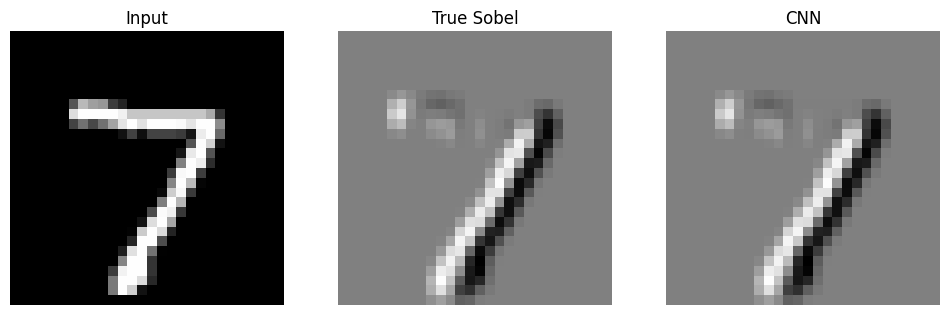


Training MLP
Epoch: 1/5 | Train loss: 0.011637, Val loss: 0.001696
Epoch: 2/5 | Train loss: 0.000758, Val loss: 0.000264
Epoch: 3/5 | Train loss: 0.000128, Val loss: 0.000060
Epoch: 4/5 | Train loss: 0.000034, Val loss: 0.000032
Epoch: 5/5 | Train loss: 0.000022, Val loss: 0.000044
MLP vs Sobel 3×3 MSE: 0.000036


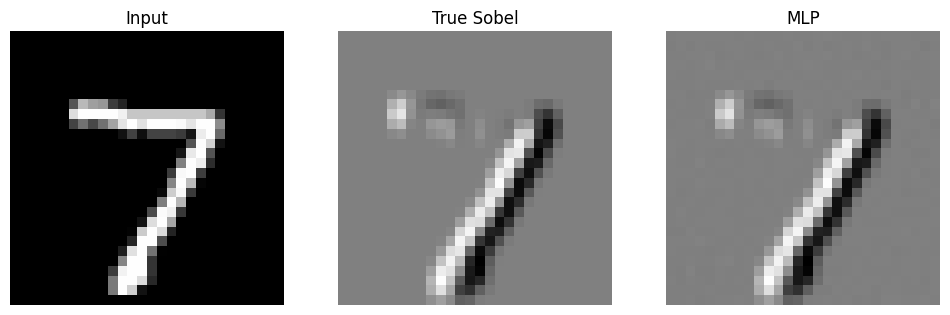


~~~ Sobel 5×5 ~~~
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])

Training CNN
Epoch: 1/5 | Train loss: 0.027129, Val loss: 0.001668
Epoch: 2/5 | Train loss: 0.000609, Val loss: 0.000148
Epoch: 3/5 | Train loss: 0.000062, Val loss: 0.000017
Epoch: 4/5 | Train loss: 0.000006, Val loss: 0.000001
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 5×5 MSE: 0.000000


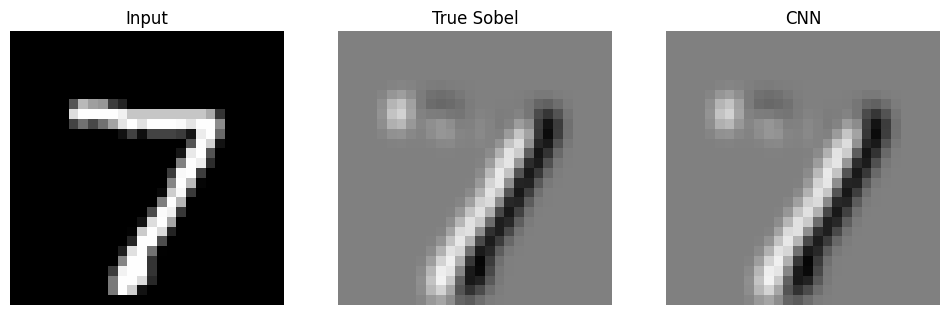


Training MLP
Epoch: 1/5 | Train loss: 0.020677, Val loss: 0.001293
Epoch: 2/5 | Train loss: 0.000503, Val loss: 0.000148
Epoch: 3/5 | Train loss: 0.000073, Val loss: 0.000036
Epoch: 4/5 | Train loss: 0.000024, Val loss: 0.000014
Epoch: 5/5 | Train loss: 0.000019, Val loss: 0.000013
MLP vs Sobel 5×5 MSE: 0.000011


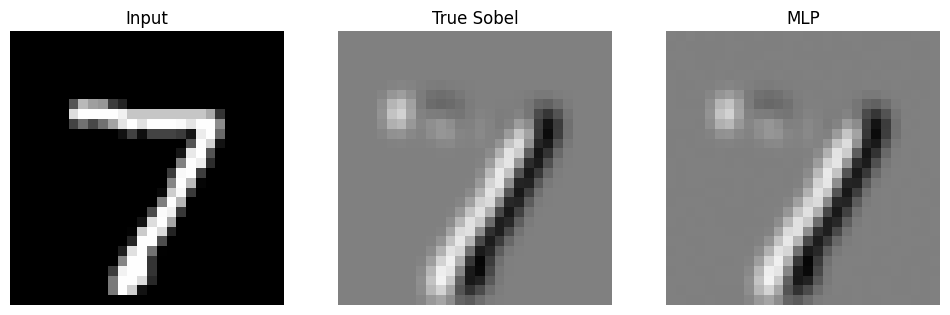


~~~ Sobel 7×7 ~~~
tensor([[-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.1243, -0.2487, -0.3730,  0.0000,  0.3730,  0.2487,  0.1243],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062]])

Training CNN
Epoch: 1/5 | Train loss: 0.028184, Val loss: 0.000766
Epoch: 2/5 | Train loss: 0.000335, Val loss: 0.000128
Epoch: 3/5 | Train loss: 0.000073, Val loss: 0.000035
Epoch: 4/5 | Train loss: 0.000019, Val loss: 0.000008
Epoch: 5/5 | Train loss: 0.000004, Val loss: 0.000001
CNN vs Sobel 7×7 MSE: 0.000001


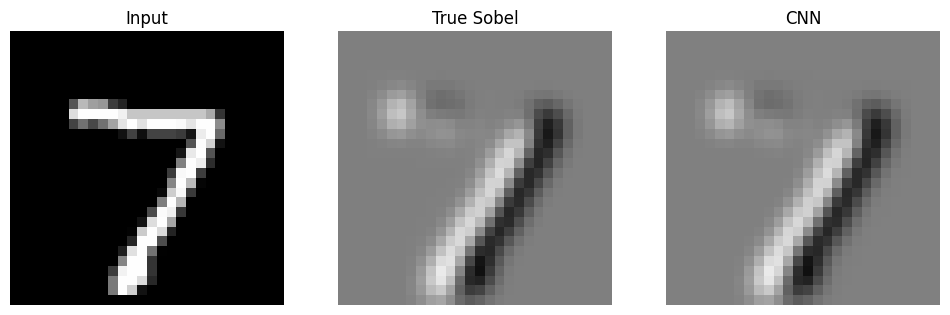


Training MLP
Epoch: 1/5 | Train loss: 0.026864, Val loss: 0.000945
Epoch: 2/5 | Train loss: 0.000362, Val loss: 0.000114
Epoch: 3/5 | Train loss: 0.000057, Val loss: 0.000026
Epoch: 4/5 | Train loss: 0.000021, Val loss: 0.000019
Epoch: 5/5 | Train loss: 0.000021, Val loss: 0.000032
MLP vs Sobel 7×7 MSE: 0.000027


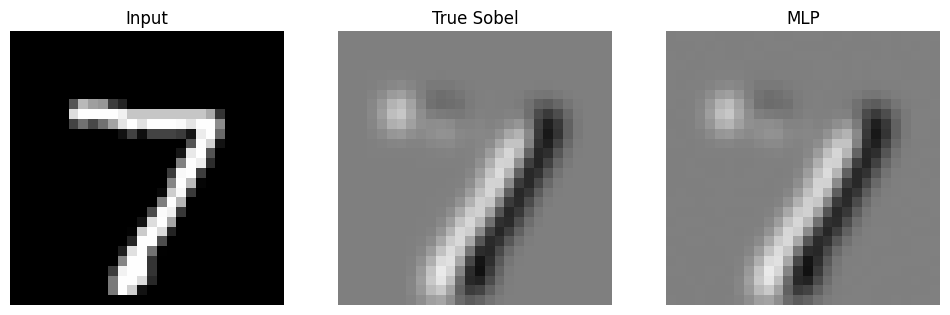


~~~ Sobel 9×9 ~~~
tensor([[-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.3186, -0.2390, -0.1593, -0.0797,  0.0000,  0.0797,  0.1593,  0.2390,
          0.3186],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046]])

Training CNN
Epoch: 1/5 | Train loss: 0.060148, Val loss: 0.001046
Epoch: 2/5 |

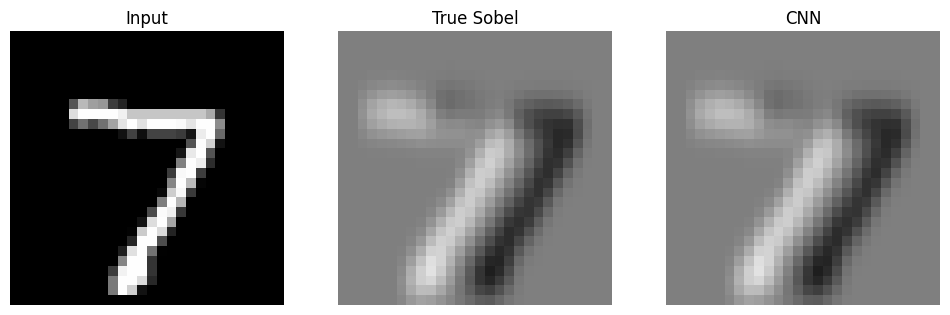


Training MLP
Epoch: 1/5 | Train loss: 0.034713, Val loss: 0.001299
Epoch: 2/5 | Train loss: 0.000558, Val loss: 0.000210
Epoch: 3/5 | Train loss: 0.000107, Val loss: 0.000048
Epoch: 4/5 | Train loss: 0.000028, Val loss: 0.000028
Epoch: 5/5 | Train loss: 0.000017, Val loss: 0.000022
MLP vs Sobel 9×9 MSE: 0.000020


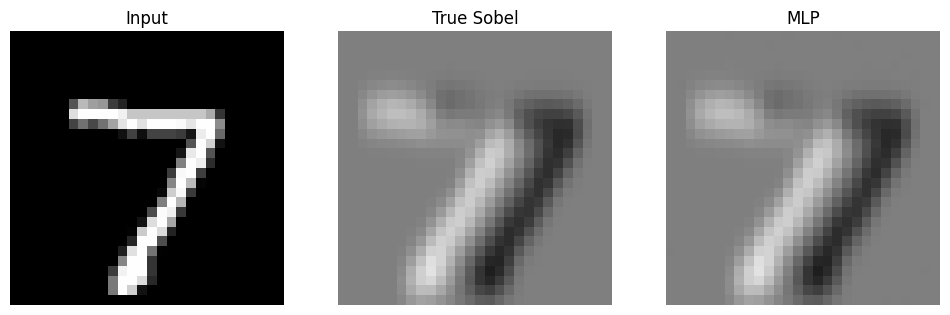


---- Noise level: 0.05 ----

~~~ Sobel 3×3 ~~~
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])

Training CNN
Epoch: 1/5 | Train loss: 0.036386, Val loss: 0.001783
Epoch: 2/5 | Train loss: 0.000998, Val loss: 0.000279
Epoch: 3/5 | Train loss: 0.000226, Val loss: 0.000067
Epoch: 4/5 | Train loss: 0.000050, Val loss: 0.000010
Epoch: 5/5 | Train loss: 0.000005, Val loss: 0.000000
CNN vs Sobel 3×3 MSE: 0.000000


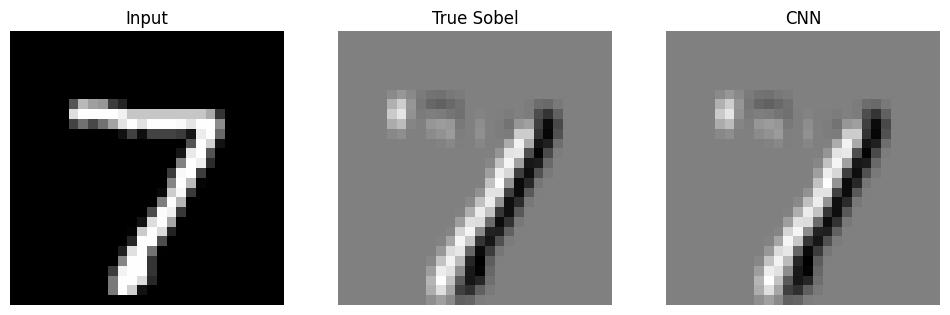


Training MLP
Epoch: 1/5 | Train loss: 0.012598, Val loss: 0.001413
Epoch: 2/5 | Train loss: 0.000690, Val loss: 0.000144
Epoch: 3/5 | Train loss: 0.000070, Val loss: 0.000023
Epoch: 4/5 | Train loss: 0.000018, Val loss: 0.000015
Epoch: 5/5 | Train loss: 0.000023, Val loss: 0.000028
MLP vs Sobel 3×3 MSE: 0.000022


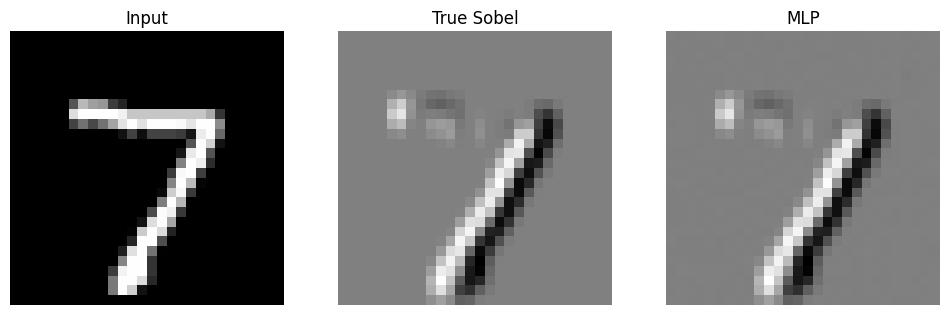


~~~ Sobel 5×5 ~~~
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])

Training CNN
Epoch: 1/5 | Train loss: 0.022251, Val loss: 0.001038
Epoch: 2/5 | Train loss: 0.000491, Val loss: 0.000081
Epoch: 3/5 | Train loss: 0.000049, Val loss: 0.000007
Epoch: 4/5 | Train loss: 0.000004, Val loss: 0.000000
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 5×5 MSE: 0.000000


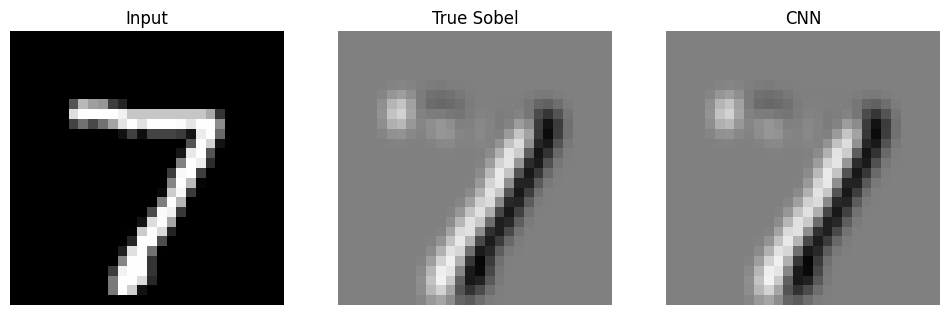


Training MLP
Epoch: 1/5 | Train loss: 0.021345, Val loss: 0.001065
Epoch: 2/5 | Train loss: 0.000447, Val loss: 0.000080
Epoch: 3/5 | Train loss: 0.000041, Val loss: 0.000014
Epoch: 4/5 | Train loss: 0.000016, Val loss: 0.000011
Epoch: 5/5 | Train loss: 0.000021, Val loss: 0.000033
MLP vs Sobel 5×5 MSE: 0.000029


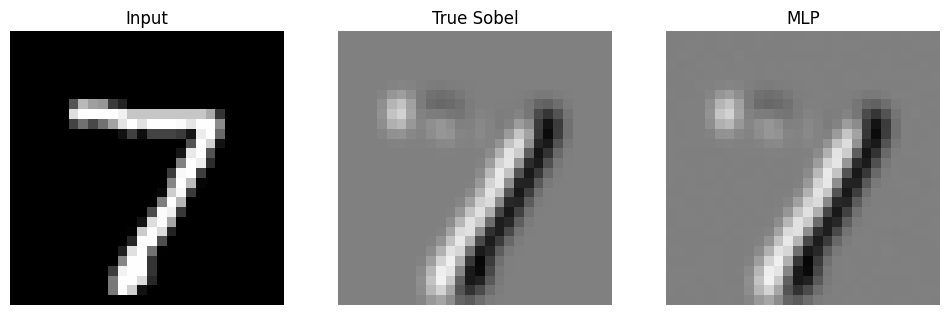


~~~ Sobel 7×7 ~~~
tensor([[-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.1243, -0.2487, -0.3730,  0.0000,  0.3730,  0.2487,  0.1243],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062]])

Training CNN
Epoch: 1/5 | Train loss: 0.025860, Val loss: 0.001028
Epoch: 2/5 | Train loss: 0.000469, Val loss: 0.000082
Epoch: 3/5 | Train loss: 0.000051, Val loss: 0.000009
Epoch: 4/5 | Train loss: 0.000006, Val loss: 0.000001
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 7×7 MSE: 0.000000


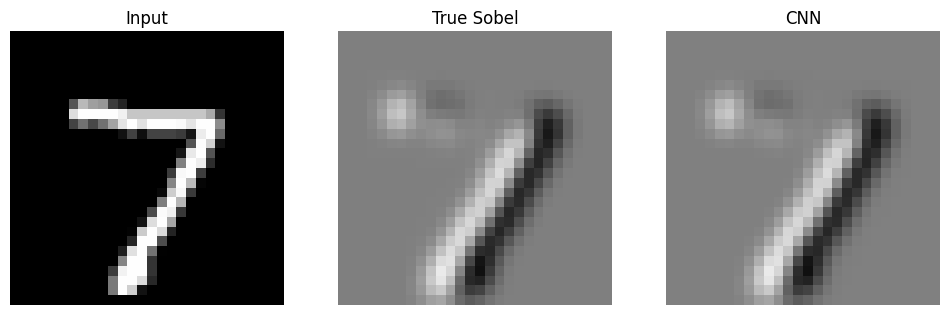


Training MLP
Epoch: 1/5 | Train loss: 0.027317, Val loss: 0.000768
Epoch: 2/5 | Train loss: 0.000321, Val loss: 0.000059
Epoch: 3/5 | Train loss: 0.000034, Val loss: 0.000013
Epoch: 4/5 | Train loss: 0.000015, Val loss: 0.000013
Epoch: 5/5 | Train loss: 0.000022, Val loss: 0.000021
MLP vs Sobel 7×7 MSE: 0.000017


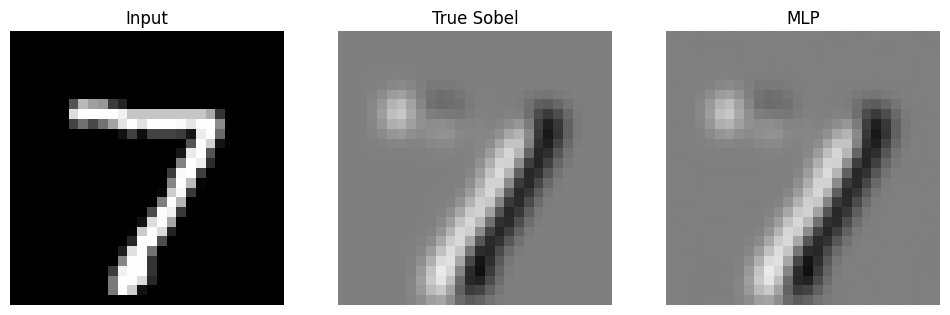


~~~ Sobel 9×9 ~~~
tensor([[-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.3186, -0.2390, -0.1593, -0.0797,  0.0000,  0.0797,  0.1593,  0.2390,
          0.3186],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046]])

Training CNN
Epoch: 1/5 | Train loss: 0.051348, Val loss: 0.000822
Epoch: 2/5 |

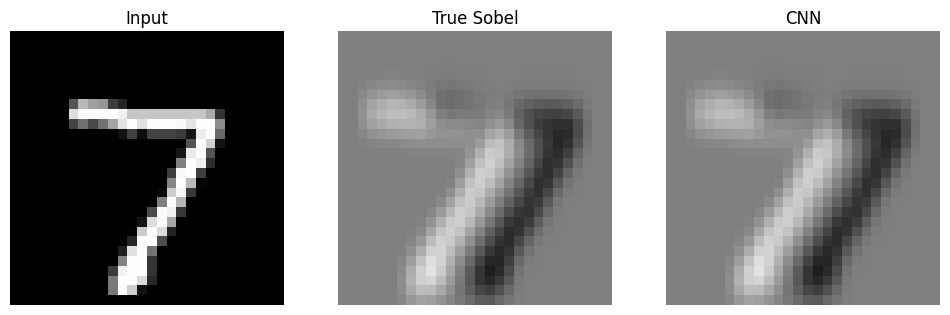


Training MLP
Epoch: 1/5 | Train loss: 0.035072, Val loss: 0.001098
Epoch: 2/5 | Train loss: 0.000534, Val loss: 0.000135
Epoch: 3/5 | Train loss: 0.000078, Val loss: 0.000024
Epoch: 4/5 | Train loss: 0.000018, Val loss: 0.000016
Epoch: 5/5 | Train loss: 0.000016, Val loss: 0.000018
MLP vs Sobel 9×9 MSE: 0.000016


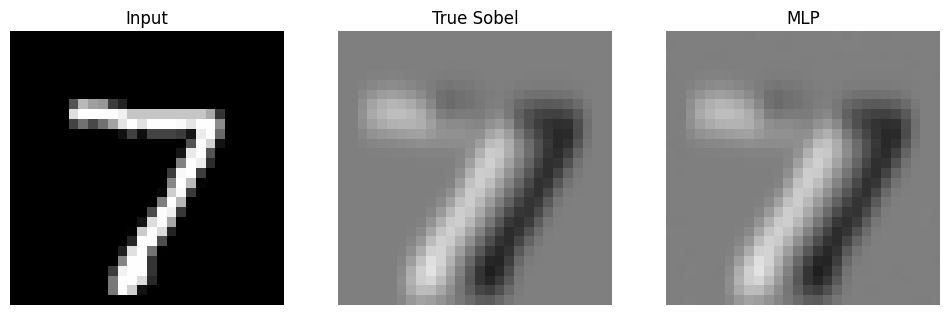


---- Noise level: 0.1 ----

~~~ Sobel 3×3 ~~~
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])

Training CNN
Epoch: 1/5 | Train loss: 0.008023, Val loss: 0.000043
Epoch: 2/5 | Train loss: 0.000026, Val loss: 0.000000
Epoch: 3/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 3×3 MSE: 0.000000


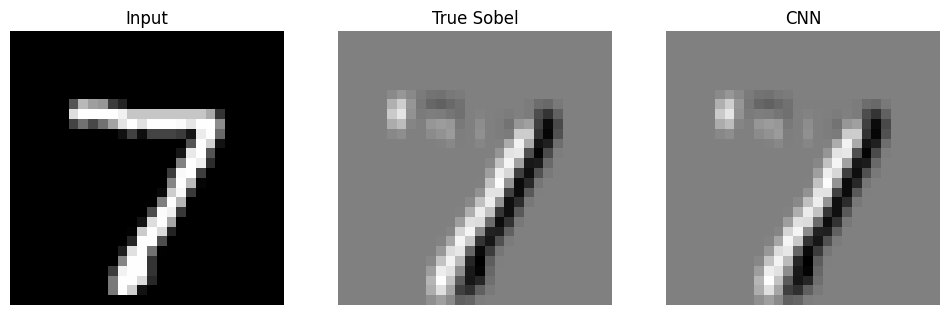


Training MLP
Epoch: 1/5 | Train loss: 0.014997, Val loss: 0.001009
Epoch: 2/5 | Train loss: 0.000567, Val loss: 0.000051
Epoch: 3/5 | Train loss: 0.000029, Val loss: 0.000002
Epoch: 4/5 | Train loss: 0.000012, Val loss: 0.000037
Epoch: 5/5 | Train loss: 0.000034, Val loss: 0.000024
MLP vs Sobel 3×3 MSE: 0.000021


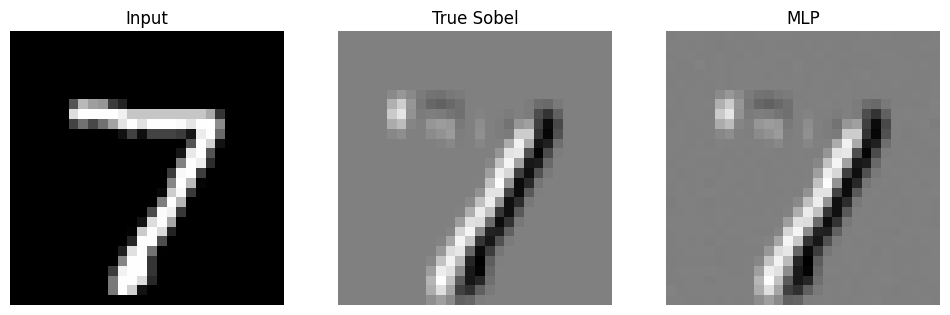


~~~ Sobel 5×5 ~~~
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])

Training CNN
Epoch: 1/5 | Train loss: 0.015046, Val loss: 0.000322
Epoch: 2/5 | Train loss: 0.000183, Val loss: 0.000006
Epoch: 3/5 | Train loss: 0.000003, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 5×5 MSE: 0.000000


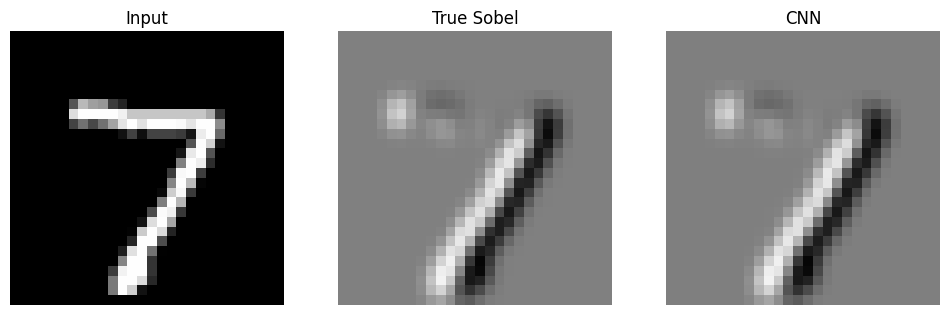


Training MLP
Epoch: 1/5 | Train loss: 0.023269, Val loss: 0.000766
Epoch: 2/5 | Train loss: 0.000356, Val loss: 0.000032
Epoch: 3/5 | Train loss: 0.000018, Val loss: 0.000002
Epoch: 4/5 | Train loss: 0.000017, Val loss: 0.000040
Epoch: 5/5 | Train loss: 0.000027, Val loss: 0.000018
MLP vs Sobel 5×5 MSE: 0.000014


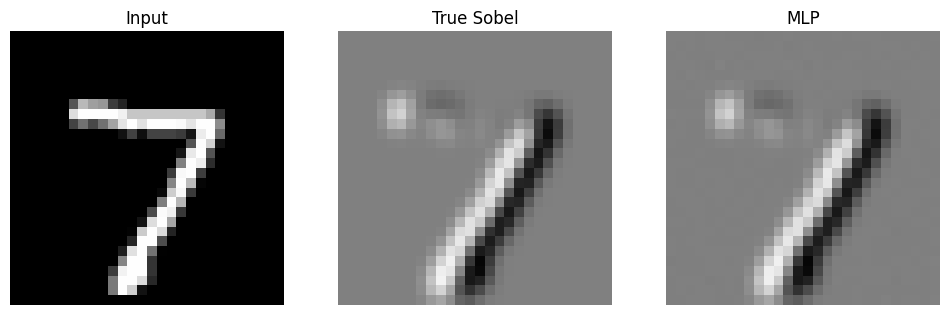


~~~ Sobel 7×7 ~~~
tensor([[-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.1243, -0.2487, -0.3730,  0.0000,  0.3730,  0.2487,  0.1243],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062]])

Training CNN
Epoch: 1/5 | Train loss: 0.043471, Val loss: 0.000772
Epoch: 2/5 | Train loss: 0.000503, Val loss: 0.000036
Epoch: 3/5 | Train loss: 0.000034, Val loss: 0.000001
Epoch: 4/5 | Train loss: 0.000001, Val loss: 0.000000
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 7×7 MSE: 0.000000


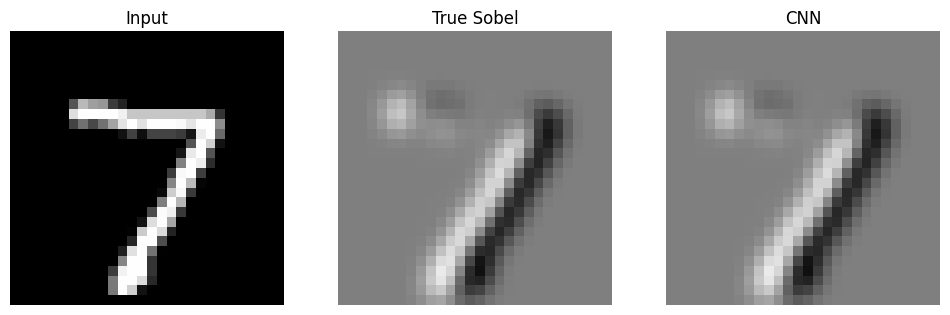


Training MLP
Epoch: 1/5 | Train loss: 0.029406, Val loss: 0.000557
Epoch: 2/5 | Train loss: 0.000257, Val loss: 0.000023
Epoch: 3/5 | Train loss: 0.000014, Val loss: 0.000002
Epoch: 4/5 | Train loss: 0.000017, Val loss: 0.000036
Epoch: 5/5 | Train loss: 0.000026, Val loss: 0.000015
MLP vs Sobel 7×7 MSE: 0.000013


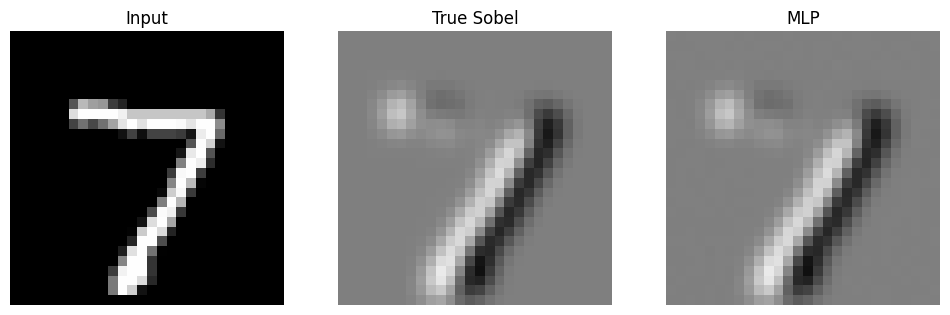


~~~ Sobel 9×9 ~~~
tensor([[-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.3186, -0.2390, -0.1593, -0.0797,  0.0000,  0.0797,  0.1593,  0.2390,
          0.3186],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046]])

Training CNN
Epoch: 1/5 | Train loss: 0.065726, Val loss: 0.001027
Epoch: 2/5 |

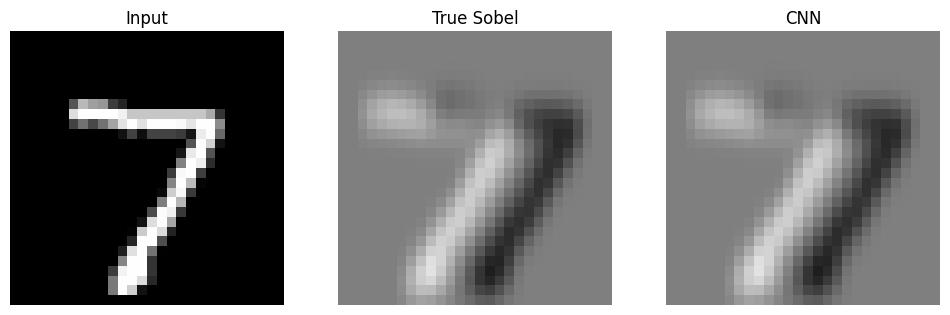


Training MLP
Epoch: 1/5 | Train loss: 0.036288, Val loss: 0.000785
Epoch: 2/5 | Train loss: 0.000433, Val loss: 0.000057
Epoch: 3/5 | Train loss: 0.000037, Val loss: 0.000006
Epoch: 4/5 | Train loss: 0.000014, Val loss: 0.000014
Epoch: 5/5 | Train loss: 0.000021, Val loss: 0.000018
MLP vs Sobel 9×9 MSE: 0.000018


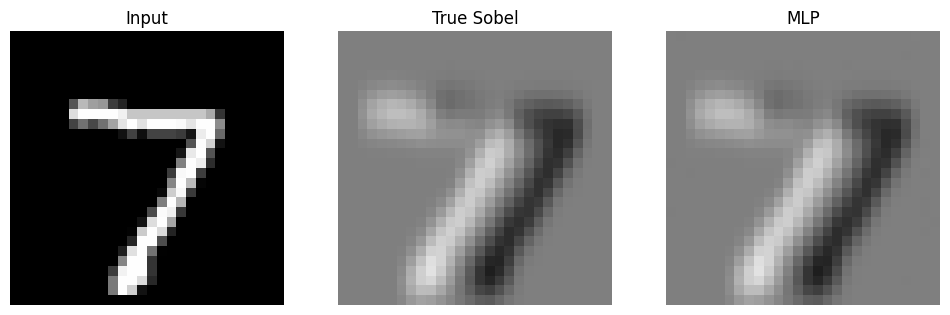


---- Noise level: 0.2 ----

~~~ Sobel 3×3 ~~~
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])

Training CNN
Epoch: 1/5 | Train loss: 0.016231, Val loss: 0.000176
Epoch: 2/5 | Train loss: 0.000163, Val loss: 0.000000
Epoch: 3/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 3×3 MSE: 0.000000


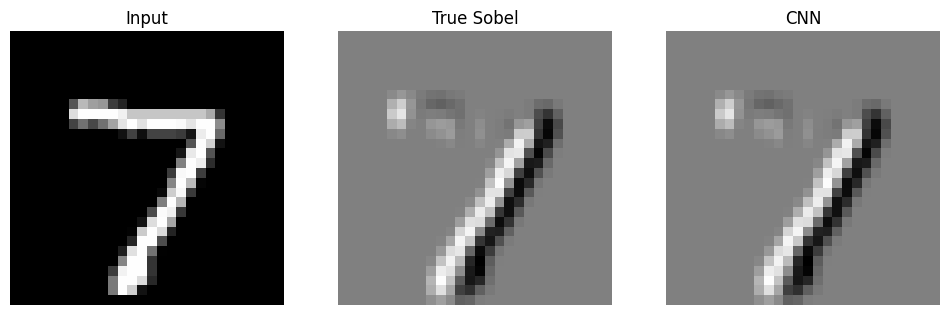


Training MLP
Epoch: 1/5 | Train loss: 0.023551, Val loss: 0.000483
Epoch: 2/5 | Train loss: 0.000356, Val loss: 0.000005
Epoch: 3/5 | Train loss: 0.000003, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000000, Val loss: 0.000001
Epoch: 5/5 | Train loss: 0.000048, Val loss: 0.000060
MLP vs Sobel 3×3 MSE: 0.000051


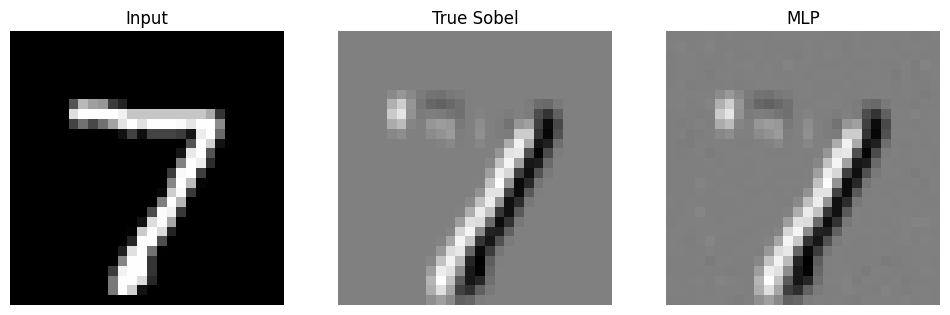


~~~ Sobel 5×5 ~~~
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])

Training CNN
Epoch: 1/5 | Train loss: 0.051395, Val loss: 0.000571
Epoch: 2/5 | Train loss: 0.000585, Val loss: 0.000003
Epoch: 3/5 | Train loss: 0.000003, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 5×5 MSE: 0.000000


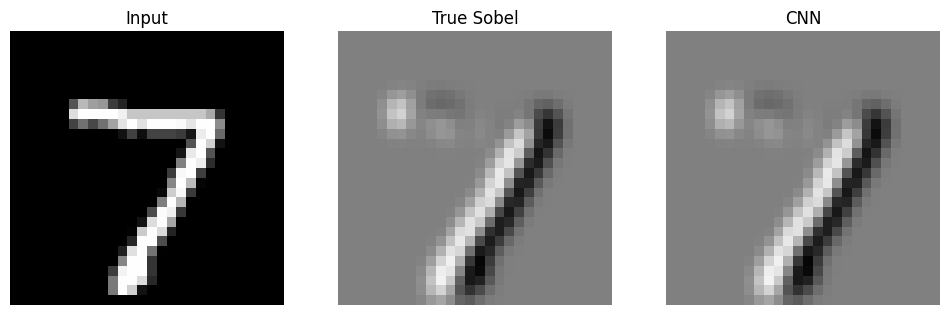


Training MLP
Epoch: 1/5 | Train loss: 0.029613, Val loss: 0.000341
Epoch: 2/5 | Train loss: 0.000193, Val loss: 0.000003
Epoch: 3/5 | Train loss: 0.000002, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000003, Val loss: 0.000016
Epoch: 5/5 | Train loss: 0.000057, Val loss: 0.000037
MLP vs Sobel 5×5 MSE: 0.000034


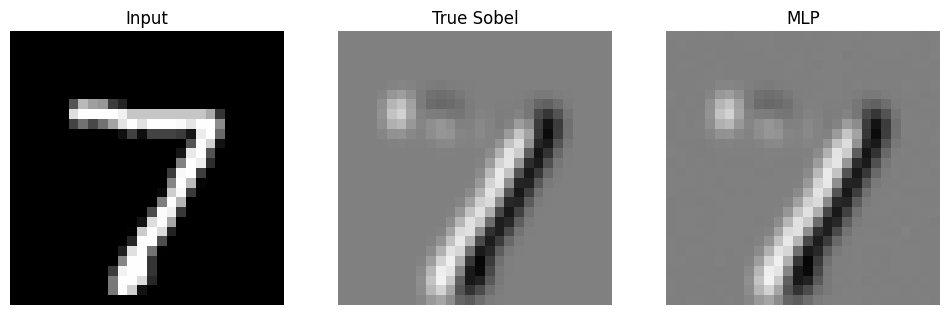


~~~ Sobel 7×7 ~~~
tensor([[-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.1243, -0.2487, -0.3730,  0.0000,  0.3730,  0.2487,  0.1243],
        [-0.0933, -0.1865, -0.2798,  0.0000,  0.2798,  0.1865,  0.0933],
        [-0.0373, -0.0746, -0.1119,  0.0000,  0.1119,  0.0746,  0.0373],
        [-0.0062, -0.0124, -0.0187,  0.0000,  0.0187,  0.0124,  0.0062]])

Training CNN
Epoch: 1/5 | Train loss: 0.048005, Val loss: 0.000221
Epoch: 2/5 | Train loss: 0.000140, Val loss: 0.000000
Epoch: 3/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000000, Val loss: 0.000000
Epoch: 5/5 | Train loss: 0.000000, Val loss: 0.000000
CNN vs Sobel 7×7 MSE: 0.000000


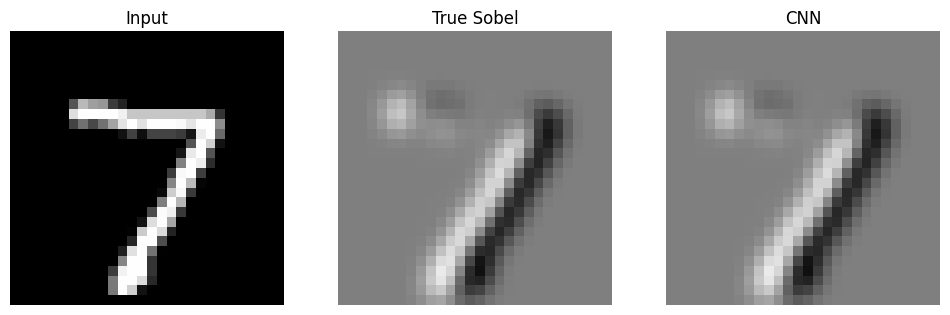


Training MLP
Epoch: 1/5 | Train loss: 0.034505, Val loss: 0.000235
Epoch: 2/5 | Train loss: 0.000123, Val loss: 0.000002
Epoch: 3/5 | Train loss: 0.000001, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000008, Val loss: 0.000016
Epoch: 5/5 | Train loss: 0.000059, Val loss: 0.000044
MLP vs Sobel 7×7 MSE: 0.000036


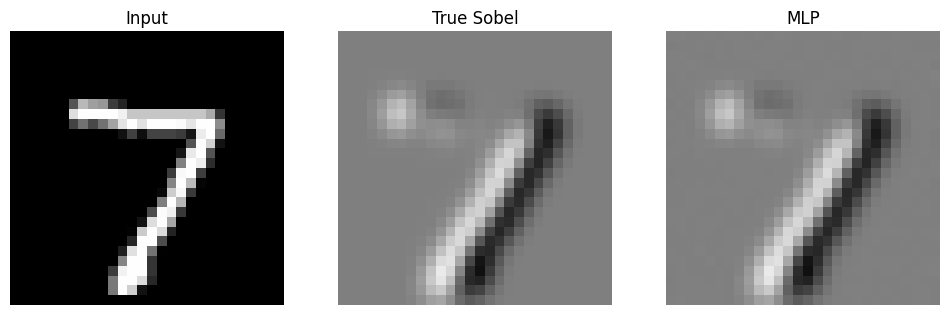


~~~ Sobel 9×9 ~~~
tensor([[-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.3186, -0.2390, -0.1593, -0.0797,  0.0000,  0.0797,  0.1593,  0.2390,
          0.3186],
        [-0.2549, -0.1912, -0.1275, -0.0637,  0.0000,  0.0637,  0.1275,  0.1912,
          0.2549],
        [-0.1275, -0.0956, -0.0637, -0.0319,  0.0000,  0.0319,  0.0637,  0.0956,
          0.1275],
        [-0.0364, -0.0273, -0.0182, -0.0091,  0.0000,  0.0091,  0.0182,  0.0273,
          0.0364],
        [-0.0046, -0.0034, -0.0023, -0.0011,  0.0000,  0.0011,  0.0023,  0.0034,
          0.0046]])

Training CNN
Epoch: 1/5 | Train loss: 0.068229, Val loss: 0.000294
Epoch: 2/5 |

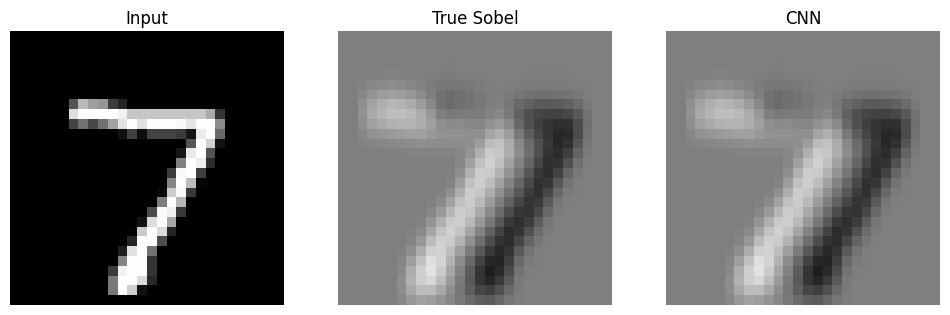


Training MLP
Epoch: 1/5 | Train loss: 0.042223, Val loss: 0.000356
Epoch: 2/5 | Train loss: 0.000232, Val loss: 0.000007
Epoch: 3/5 | Train loss: 0.000005, Val loss: 0.000000
Epoch: 4/5 | Train loss: 0.000011, Val loss: 0.000028
Epoch: 5/5 | Train loss: 0.000043, Val loss: 0.000037
MLP vs Sobel 9×9 MSE: 0.000029


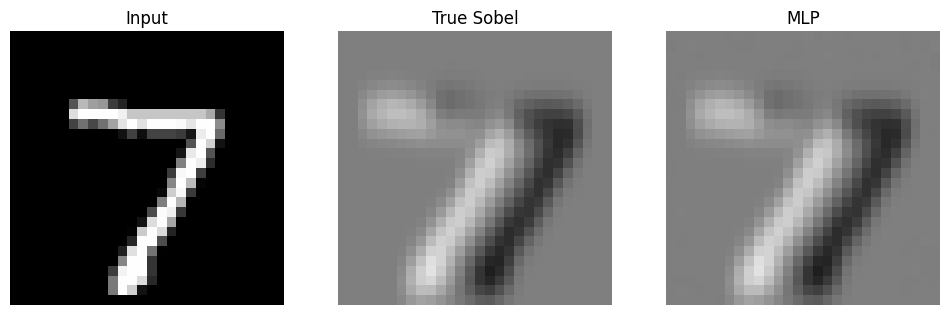

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device, CNNs tend to run better on GPU (CUDA)
kernels = [sobel_kernel, sobel_kernel5, sobel_kernel7, sobel_kernel9] #our sobel kernels of odd sizes 3 through 9.
noise_levels = [0.0, 0.05, 0.1, 0.2] # the standard deviation for our Gaussian noise. 
model_classes = [CNN, MLP]  # our models, can add Transformer back in. 

experiment = SobelExperiment(kernels, noise_levels, model_classes, device)
experiment.run()



---- Noise level: 0.0 ----

~~~ Sobel 3×3 ~~~
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])

Training Transformer
Epoch: 1/5 | Train loss: 0.098601, Val loss: 0.096614
Epoch: 2/5 | Train loss: 0.095704, Val loss: 0.096607
Epoch: 3/5 | Train loss: 0.095688, Val loss: 0.096600
Epoch: 4/5 | Train loss: 0.095676, Val loss: 0.096590
Epoch: 5/5 | Train loss: 0.095673, Val loss: 0.096580
Transformer vs Sobel 3×3 MSE: 0.096471


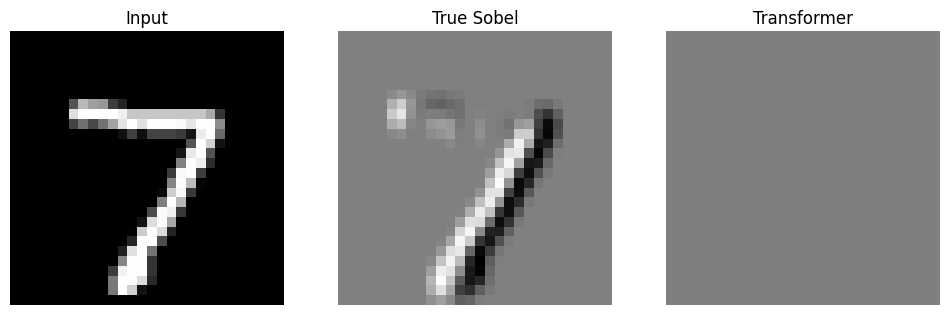


~~~ Sobel 5×5 ~~~
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])

Training Transformer
Epoch: 1/5 | Train loss: 0.238475, Val loss: 0.240388
Epoch: 2/5 | Train loss: 0.235829, Val loss: 0.240390
Epoch: 3/5 | Train loss: 0.235824, Val loss: 0.240393
Epoch: 4/5 | Train loss: 0.235831, Val loss: 0.240388
Epoch: 5/5 | Train loss: 0.235824, Val loss: 0.240388
Transformer vs Sobel 5×5 MSE: 0.231811


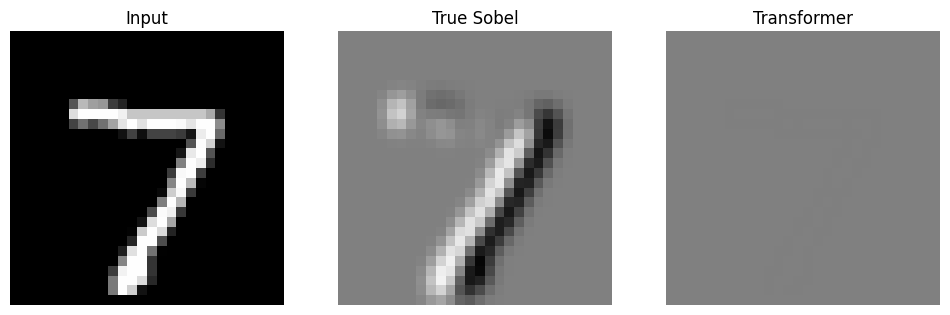


---- Noise level: 0.1 ----

~~~ Sobel 3×3 ~~~
tensor([[-0.2887,  0.0000,  0.2887],
        [-0.5774,  0.0000,  0.5774],
        [-0.2887,  0.0000,  0.2887]])

Training Transformer
Epoch: 1/5 | Train loss: 0.106772, Val loss: 0.096580
Epoch: 2/5 | Train loss: 0.105189, Val loss: 0.096581
Epoch: 3/5 | Train loss: 0.105171, Val loss: 0.096576
Epoch: 4/5 | Train loss: 0.105180, Val loss: 0.096579
Epoch: 5/5 | Train loss: 0.105194, Val loss: 0.096573
Transformer vs Sobel 3×3 MSE: 0.096464


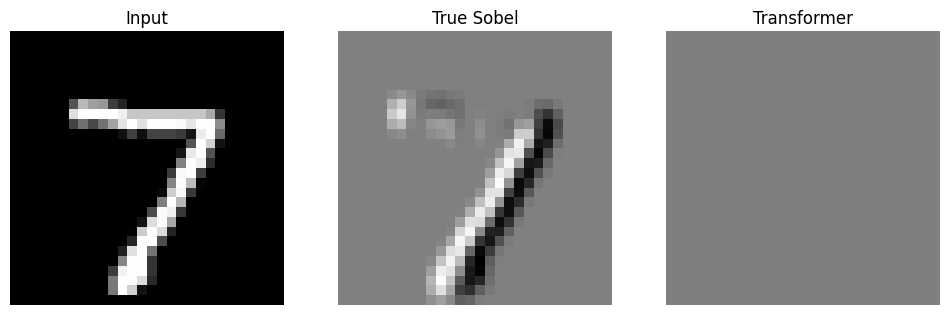


~~~ Sobel 5×5 ~~~
tensor([[-0.0378, -0.0756,  0.0000,  0.0756,  0.0378],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.2268, -0.4536,  0.0000,  0.4536,  0.2268],
        [-0.1512, -0.3024,  0.0000,  0.3024,  0.1512],
        [-0.0378, -0.0756,  0.0000,  0.0756,  0.0378]])

Training Transformer
Epoch: 1/5 | Train loss: 0.249205, Val loss: 0.240424
Epoch: 2/5 | Train loss: 0.245211, Val loss: 0.240423
Epoch: 3/5 | Train loss: 0.245187, Val loss: 0.240420
Epoch: 4/5 | Train loss: 0.245286, Val loss: 0.240418
Epoch: 5/5 | Train loss: 0.245214, Val loss: 0.240400
Transformer vs Sobel 5×5 MSE: 0.231826


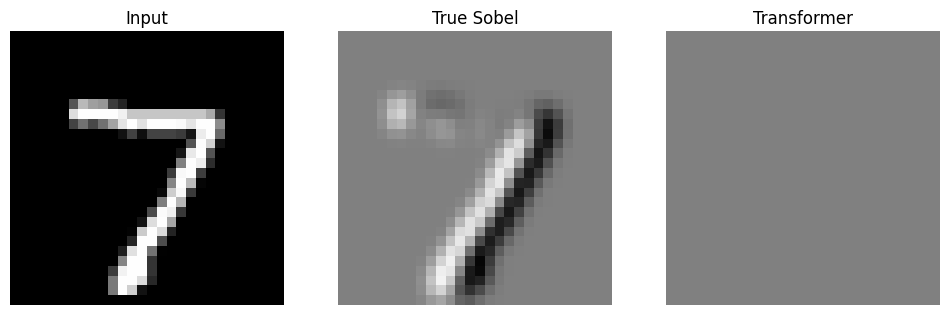

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kernels = [sobel_kernel, sobel_kernel5]
noise_levels = [0.0, 0.1]
model_classes = [Transformer]

experiment = SobelExperiment(kernels, noise_levels, model_classes, device)
experiment.run()